In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import warnings
import kagglehub
import os

warnings.filterwarnings('ignore')

# Set visualization styles
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")


In [ ]:
# Download latest version
path = kagglehub.dataset_download("vijayuv/onlineretail")

print("Path to dataset files:", path)

# List files in the downloaded directory to find the correct file name
print("\nFiles in the downloaded directory:")
print(os.listdir(path))

# Assuming the CSV file is named 'OnlineRetail.csv' within the downloaded path
csv_file_path = os.path.join(path, 'OnlineRetail.csv')

# Load the data into a pandas DataFrame
df = pd.read_csv(csv_file_path, encoding='ISO-8859-1')


# Display the first few rows
print("Sample data:")
display(df.head())

# Check basic information
print("\nDataset info:")
df.info()

# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())

Using Colab cache for faster access to the 'onlineretail' dataset.
Path to dataset files: /kaggle/input/onlineretail

Files in the downloaded directory:
['OnlineRetail.csv']
Sample data:


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom



Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB

Missing values per column:
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


Data Cleaning and Normalization

In [ ]:
def clean_data(df):
    """
    Clean and normalize the Online Retail dataset
    """
    # Create a copy to avoid modifying the original
    df_clean = df.copy()

    # Convert InvoiceDate to datetime
    df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])

    # Extract date components
    df_clean['Year'] = df_clean['InvoiceDate'].dt.year
    df_clean['Month'] = df_clean['InvoiceDate'].dt.month
    df_clean['Day'] = df_clean['InvoiceDate'].dt.day
    df_clean['DayOfWeek'] = df_clean['InvoiceDate'].dt.dayofweek
    df_clean['Hour'] = df_clean['InvoiceDate'].dt.hour

    # Create Season column
    season_mapping = {
        1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring',
        5: 'Spring', 6: 'Summer', 7: 'Summer', 8: 'Summer',
        9: 'Fall', 10: 'Fall', 11: 'Fall', 12: 'Winter'
    }
    df_clean['Season'] = df_clean['Month'].map(season_mapping)

    # Filter out records with missing CustomerID
    df_clean = df_clean.dropna(subset=['CustomerID'])

    # Convert CustomerID to integer
    df_clean['CustomerID'] = df_clean['CustomerID'].astype(int)

    # Filter out cancelled orders (those with 'C' in InvoiceNo)
    df_clean = df_clean[~df_clean['InvoiceNo'].astype(str).str.contains('C')]

    # Calculate total price for each transaction
    df_clean['TotalPrice'] = df_clean['Quantity'] * df_clean['UnitPrice']

    # Remove negative quantities and prices
    df_clean = df_clean[(df_clean['Quantity'] > 0) & (df_clean['UnitPrice'] > 0)]

    # Remove outliers in Quantity and UnitPrice
    q_upper = df_clean['Quantity'].quantile(0.99)
    p_upper = df_clean['UnitPrice'].quantile(0.99)
    df_clean = df_clean[(df_clean['Quantity'] <= q_upper) & (df_clean['UnitPrice'] <= p_upper)]

    print(f"Cleaned dataset has {df_clean.shape[0]} rows and {df_clean.shape[1]} columns")
    return df_clean

# Clean the data
df_clean = clean_data(df)

# Display the cleaned data
print("Sample cleaned data:")
display(df_clean.head())

Cleaned dataset has 390260 rows and 15 columns
Sample cleaned data:


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,Day,DayOfWeek,Hour,Season,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,2010,12,1,2,8,Winter,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010,12,1,2,8,Winter,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,2010,12,1,2,8,Winter,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010,12,1,2,8,Winter,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010,12,1,2,8,Winter,20.34


Feature Engineering

In [ ]:
def engineer_features(df):
    """
    Create additional features for analysis
    """
    # Create a copy to avoid modifying the original
    df_eng = df.copy()

    # Create month-year field for time series analysis
    df_eng['MonthYear'] = df_eng['InvoiceDate'].dt.to_period('M')

    # Extract country region information (simplified approach)
    # In a real scenario, you might use a proper region mapping
    eu_countries = ['United Kingdom', 'Germany', 'France', 'Spain', 'Italy',
                    'Netherlands', 'Belgium', 'Portugal', 'Ireland', 'Poland']

    def assign_region(country):
        if country in eu_countries:
            return 'Europe'
        else:
            return 'Other'

    df_eng['Region'] = df_eng['Country'].apply(assign_region)

    # Create product category from description (simplified)
    # In a real scenario, you might use NLP or a proper category mapping
    def extract_category(desc):
        desc = str(desc).lower()
        if 'gift' in desc:
            return 'Gifts'
        elif any(word in desc for word in ['paper', 'card', 'envelope']):
            return 'Stationery'
        elif any(word in desc for word in ['bag', 'box', 'storage']):
            return 'Storage'
        elif any(word in desc for word in ['kitchen', 'plate', 'cup', 'mug']):
            return 'Kitchen'
        elif any(word in desc for word in ['christmas', 'easter', 'halloween']):
            return 'Seasonal'
        else:
            return 'Other'

    df_eng['ProductCategory'] = df_eng['Description'].apply(extract_category)

    return df_eng

# Engineer features
df_eng = engineer_features(df_clean)

# Display the engineered data
print("Sample data with engineered features:")
display(df_eng.head())

Sample data with engineered features:


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,Day,DayOfWeek,Hour,Season,TotalPrice,MonthYear,Region,ProductCategory
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,2010,12,1,2,8,Winter,15.30,2010-12,Europe,Other
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010,12,1,2,8,Winter,20.34,2010-12,Europe,Other
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,2010,12,1,2,8,Winter,22.00,2010-12,Europe,Kitchen
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010,12,1,2,8,Winter,20.34,2010-12,Europe,Other
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010,12,1,2,8,Winter,20.34,2010-12,Europe,Other


Customer Segmentation (RFM Analysis)

In [ ]:
def perform_rfm_analysis(df):
    """
    Perform RFM (Recency, Frequency, Monetary) analysis for customer segmentation
    """
    # Get the most recent date in the dataset
    max_date = df['InvoiceDate'].max() + timedelta(days=1)

    # Group by CustomerID
    rfm = df.groupby('CustomerID').agg({
        'InvoiceDate': lambda x: (max_date - x.max()).days,  # Recency
        'InvoiceNo': 'nunique',  # Frequency
        'TotalPrice': 'sum'  # Monetary
    })

    # Rename columns
    rfm.columns = ['Recency', 'Frequency', 'Monetary']

    # Create RFM segments
    r_labels = range(4, 0, -1)
    f_labels = range(1, 5)
    m_labels = range(1, 5)

    # Assign R scores
    rfm['R'] = pd.qcut(rfm['Recency'], q=4, labels=r_labels)

    # Assign F scores, handling duplicate bins by dropping them
    # Determine the number of unique bins after dropping duplicates
    try:
        f_quantiles = pd.qcut(rfm['Frequency'], q=4, duplicates='drop', retbins=True)[1]
        f_labels_adjusted = range(1, len(f_quantiles))
        rfm['F'] = pd.qcut(rfm['Frequency'], q=len(f_quantiles)-1, labels=f_labels_adjusted, duplicates='drop')
    except ValueError:
        # Handle the case where even after dropping duplicates, there's only one unique bin
        rfm['F'] = 1 # Assign all customers to a single frequency group


    # Assign M scores, handling duplicate bins by dropping them
    # Determine the number of unique bins after dropping duplicates
    try:
        m_quantiles = pd.qcut(rfm['Monetary'], q=4, duplicates='drop', retbins=True)[1]
        m_labels_adjusted = range(1, len(m_quantiles))
        rfm['M'] = pd.qcut(rfm['Monetary'], q=len(m_quantiles)-1, labels=m_labels_adjusted, duplicates='drop')
    except ValueError:
        # Handle the case where even after dropping duplicates, there's only one unique bin
        rfm['M'] = 1 # Assign all customers to a single monetary group


    # Calculate RFM Score
    rfm['RFM_Score'] = rfm['R'].astype(str) + rfm['F'].astype(str) + rfm['M'].astype(str)

    # Create customer segments
    def segment_customer(row):
        # Ensure R, F, M are treated as strings for concatenation and comparison
        rfm_score_str = str(int(row['R'])) + str(int(row['F'])) + str(int(row['M']))

        if rfm_score_str in ['444', '443', '434', '344']:
            return 'Champions'
        elif rfm_score_str in ['442', '432', '423', '343']:
            return 'Loyal Customers'
        elif rfm_score_str in ['441', '431', '421', '412']:
            return 'Potential Loyalists'
        elif rfm_score_str in ['433', '434', '343', '334']:
            return 'Recent Customers'
        elif rfm_score_str in ['331', '321', '312', '311']:
            return 'Promising'
        elif rfm_score_str in ['244', '243', '242', '241']:
            return 'Customers Needing Attention'
        elif rfm_score_str in ['234', '233', '232', '231']:
            return 'At Risk'
        elif rfm_score_str in ['224', '223', '222', '221']:
            return 'Can\'t Lose Them'
        elif rfm_score_str in ['214', '213', '212', '211']:
            return 'Hibernating'
        else:
            return 'Lost'


    rfm['CustomerSegment'] = rfm.apply(segment_customer, axis=1)

    return rfm

# Perform RFM analysis
rfm_df = perform_rfm_analysis(df_eng)

# Display RFM results
print("RFM Analysis Results:")
display(rfm_df.head())

# Merge RFM segments back to the main dataframe
df_with_segments = df_eng.merge(
    rfm_df[['CustomerSegment']],
    left_on='CustomerID',
    right_index=True
)

print("Data with customer segments:")
display(df_with_segments.head())

RFM Analysis Results:


,Recency,Frequency,Monetary,R,F,M,RFM_Score,CustomerSegment
CustomerID,,,,,,,,
12347,2,7,4060.40,4,1,4,414,Lost
12348,75,4,1186.68,2,1,3,213,Hibernating
12349,19,1,1353.80,3,1,3,313,Lost
12350,310,1,294.40,1,1,2,112,Lost
12352,36,7,1385.74,3,1,3,313,Lost


Data with customer segments:


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,Day,DayOfWeek,Hour,Season,TotalPrice,MonthYear,Region,ProductCategory,CustomerSegment
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,2010,12,1,2,8,Winter,15.30,2010-12,Europe,Other,Lost
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010,12,1,2,8,Winter,20.34,2010-12,Europe,Other,Lost
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,2010,12,1,2,8,Winter,22.00,2010-12,Europe,Kitchen,Lost
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010,12,1,2,8,Winter,20.34,2010-12,Europe,Other,Lost
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010,12,1,2,8,Winter,20.34,2010-12,Europe,Other,Lost


Exploratory Data Analysis

(array([14975., 15034., 15095., 15156., 15218., 15279.]),
 [Text(14975.0, 0, '2011-01'),
  Text(15034.0, 0, '2011-03'),
  Text(15095.0, 0, '2011-05'),
  Text(15156.0, 0, '2011-07'),
  Text(15218.0, 0, '2011-09'),
  Text(15279.0, 0, '2011-11')])

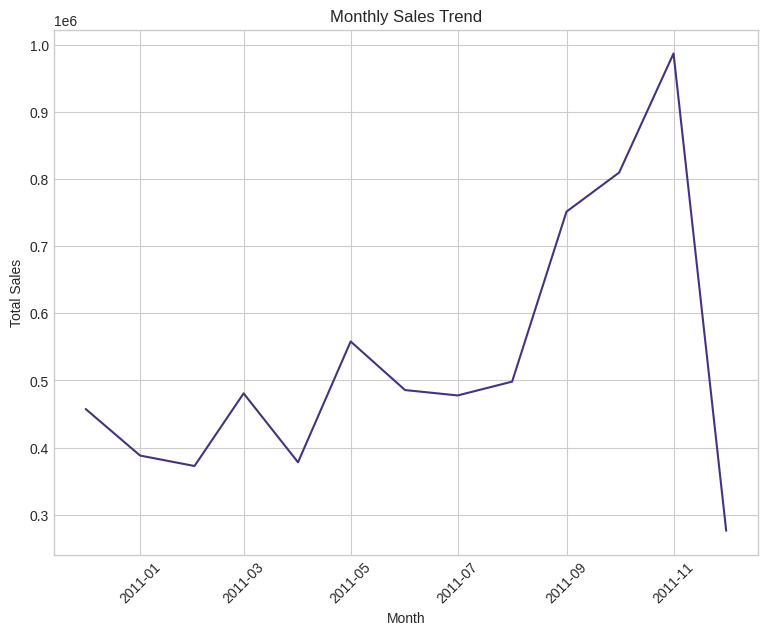

In [ ]:
# Set up the figure size
plt.figure(figsize=(20, 15))

# 1. Monthly Sales Trend
plt.subplot(2, 2, 1)
monthly_sales = df_eng.groupby(df_eng['InvoiceDate'].dt.to_period('M'))['TotalPrice'].sum().reset_index()
monthly_sales['InvoiceDate'] = monthly_sales['InvoiceDate'].dt.to_timestamp()
plt.plot(monthly_sales['InvoiceDate'], monthly_sales['TotalPrice'])
plt.title('Monthly Sales Trend')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)

There is a clear upward trend in sales throughout the year 2011.
Sales peak in November and December, indicating strong seasonality likely due to holiday shopping.

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'United Kingdom'),
  Text(1, 0, 'EIRE'),
  Text(2, 0, 'Germany'),
  Text(3, 0, 'France'),
  Text(4, 0, 'Netherlands')])

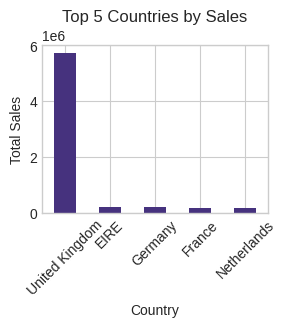

In [ ]:
# 2. Sales by Country
plt.subplot(2, 2, 2)
country_sales = df_eng.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False).head(5)
country_sales.plot(kind='bar')
plt.title('Top 5 Countries by Sales')
plt.xlabel('Country')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)

Due to the dirastic difference in these values, I believe this dataset was gathered from a UK based company and therefore no additional interest should be taken in Identifying which countries have higher sales numbers

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'Other'),
  Text(1, 0, 'Storage'),
  Text(2, 0, 'Stationery'),
  Text(3, 0, 'Kitchen'),
  Text(4, 0, 'Seasonal'),
  Text(5, 0, 'Gifts')])

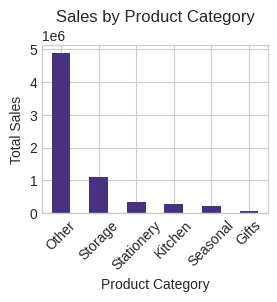

In [ ]:
# 3. Sales by Product Category
plt.subplot(2, 2, 3)
category_sales = df_eng.groupby('ProductCategory')['TotalPrice'].sum().sort_values(ascending=False)
category_sales.plot(kind='bar')
plt.title('Sales by Product Category')
plt.xlabel('Product Category')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)

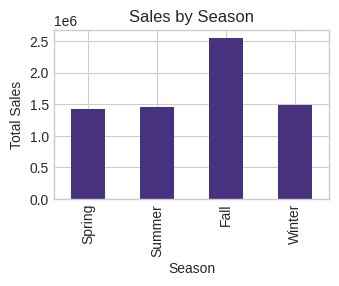

In [ ]:
# 4. Sales by Season
plt.subplot(2, 2, 4)
season_sales = df_eng.groupby('Season')['TotalPrice'].sum().reindex(['Spring', 'Summer', 'Fall', 'Winter'])
season_sales.plot(kind='bar')
plt.title('Sales by Season')
plt.xlabel('Season')
plt.ylabel('Total Sales')

plt.tight_layout()
plt.show()

 Fall has the highest sales, correlating with the peak in monthly sales observed in the time series plot (September-November).
 Winter sales are also strong, likely influenced by December holiday shopping, although the plot might be affected by the dataset ending mid-December 2011.
Spring and Summer have lower but relatively consistent sales compared to Fall and Winter.

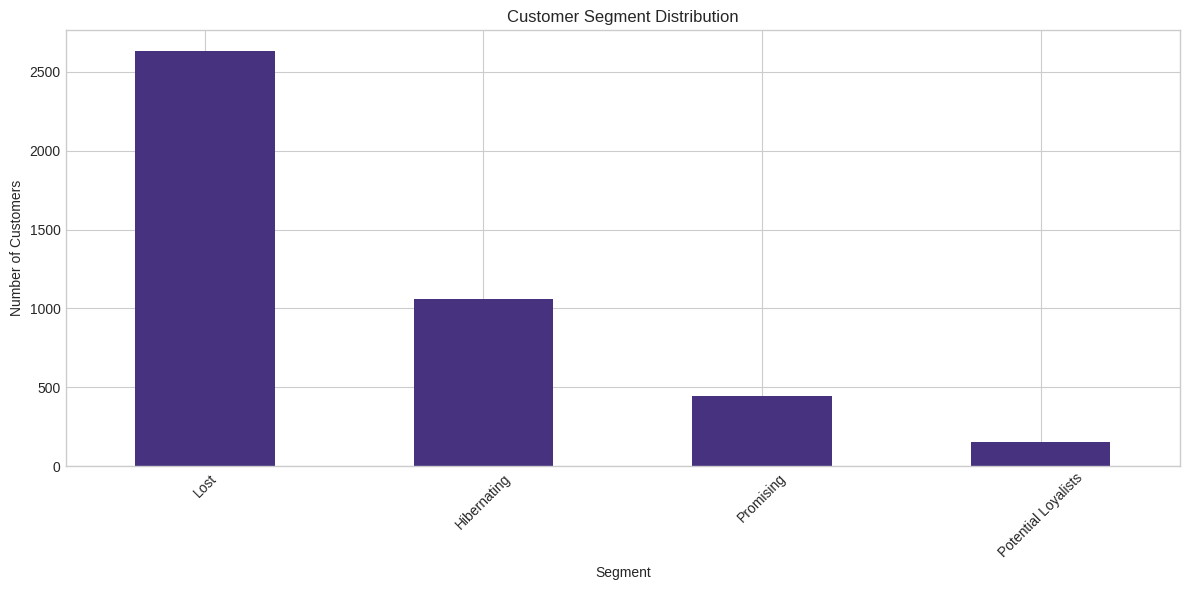

In [ ]:
# 5. Customer Segment Distribution
plt.figure(figsize=(12, 6))
segment_counts = rfm_df['CustomerSegment'].value_counts()
segment_counts.plot(kind='bar')
plt.title('Customer Segment Distribution')
plt.xlabel('Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The 'Lost' segment is the largest, indicating a significant portion of customers who have not made recent purchases, have low frequency, and low monetary value based on the RFM scoring logic.
'Hibernating' customers are the second largest group, representing customers who haven't purchased recently but might have higher frequency or monetary value than 'Lost' customers.
'Promising' and 'Potential Loyalists' are smaller but represent customers with potential for future engagement. The absence or very small numbers in high-value segments like 'Champions' suggests the RFM segmentation logic might need refinement or the customer base is heavily skewed towards infrequent/low-value buyers.

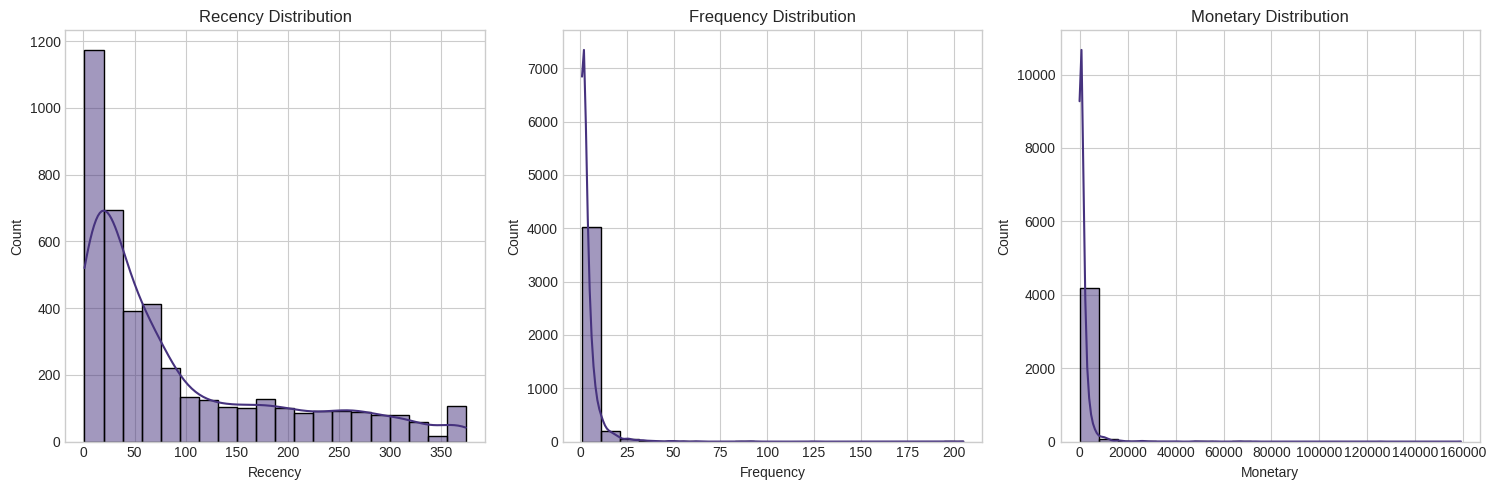

In [ ]:
# 6. RFM Score Distribution
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.histplot(rfm_df['Recency'], bins=20, kde=True)
plt.title('Recency Distribution')

plt.subplot(1, 3, 2)
sns.histplot(rfm_df['Frequency'], bins=20, kde=True)
plt.title('Frequency Distribution')

plt.subplot(1, 3, 3)
sns.histplot(rfm_df['Monetary'], bins=20, kde=True)
plt.title('Monetary Distribution')

plt.tight_layout()
plt.show()

**Recency:** The distribution is skewed towards lower recency values, meaning a good number of customers have made recent purchases. There's a long tail of customers with high recency.
 **Frequency:** The distribution is heavily skewed towards lower frequencies, indicating that most customers have made only a few purchases.
**Monetary:** The distribution is also skewed, with a large number of customers having low monetary values. There's a long tail of high-spending customers.
These distributions highlight the typical customer base of an online retail business, with a large number of infrequent, low-spending customers and a smaller group of more valuable customers.

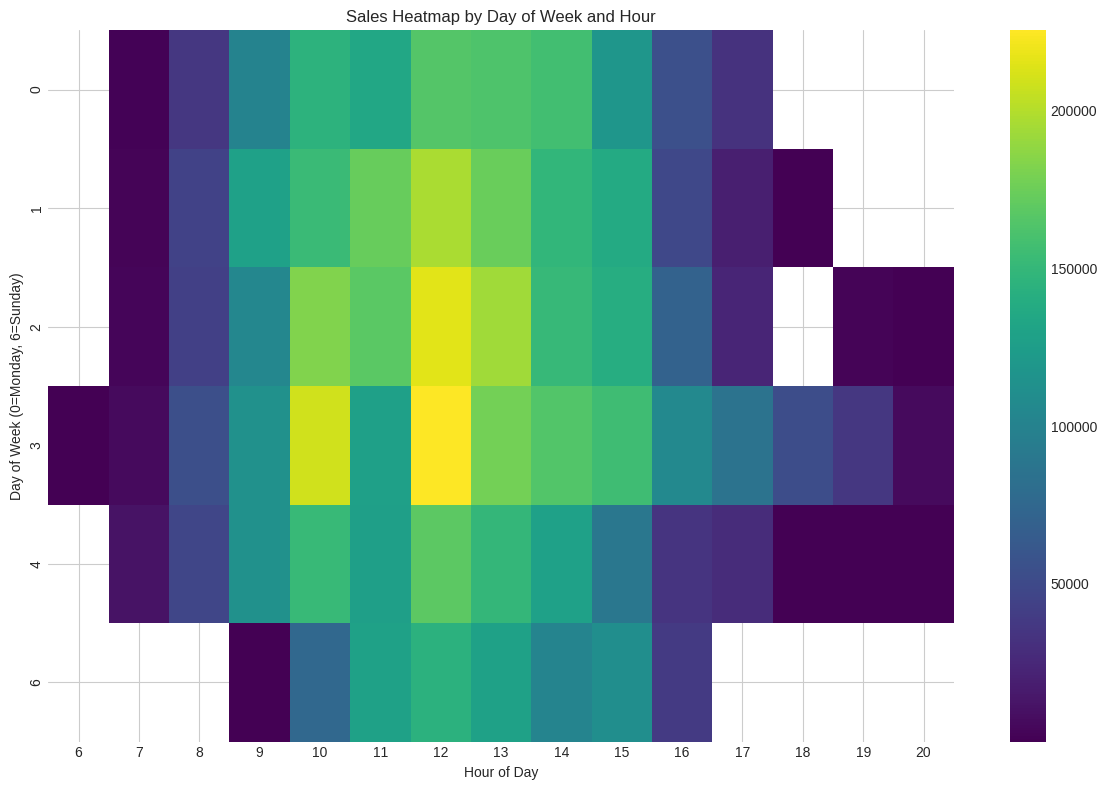

In [ ]:
# 7. Heatmap of Sales by Day of Week and Hour
plt.figure(figsize=(12, 8))
day_hour_sales = df_eng.groupby(['DayOfWeek', 'Hour'])['TotalPrice'].sum().unstack()
sns.heatmap(day_hour_sales, cmap='viridis', annot=False)
plt.title('Sales Heatmap by Day of Week and Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week (0=Monday, 6=Sunday)')
plt.tight_layout()
plt.show()

Sales are generally higher during weekdays (Monday to Friday) compared to weekends (Saturday and Sunday), with Saturday having very low sales.
Peak sales hours appear to be between 10 AM and 3 PM (Hours 10-15) on weekdays.
There are very few sales in the early morning (before 8 AM) and late evening (after 7 PM).
Thursday (Day of Week 3) seems to have strong sales extending later into the afternoon.

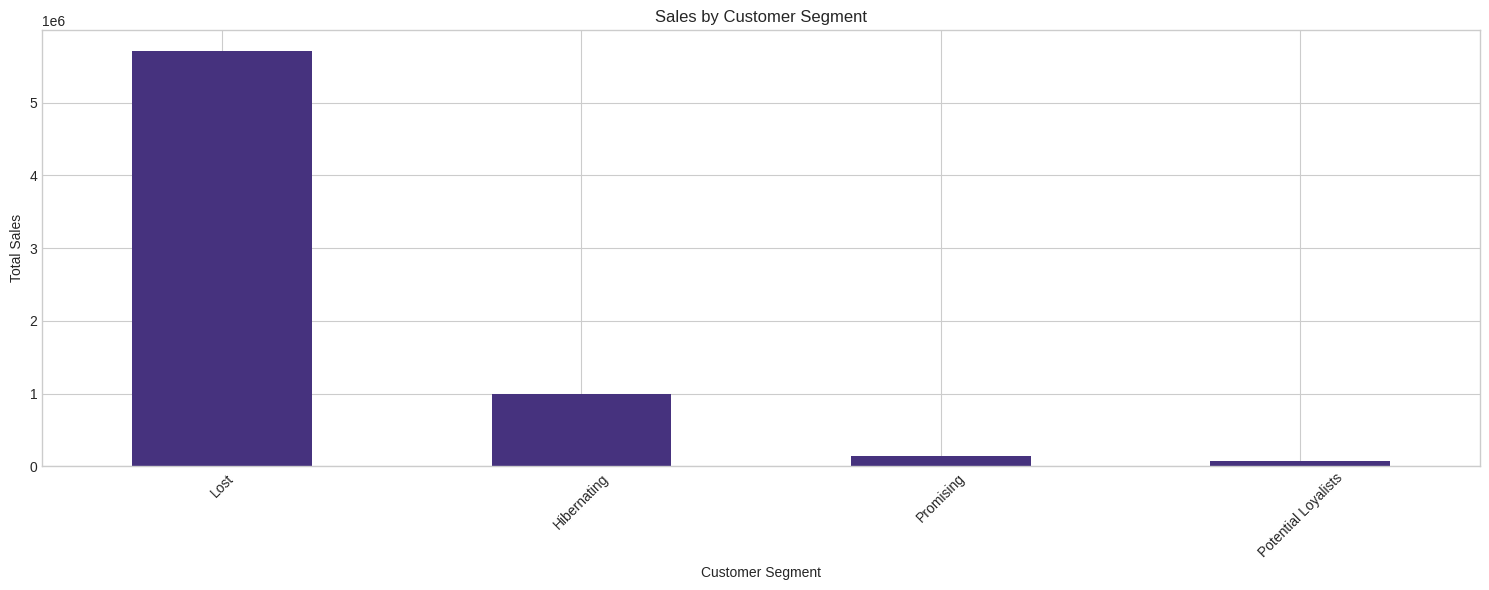

In [ ]:
# 8. Customer Segment Performance
plt.figure(figsize=(15, 6))
segment_performance = df_with_segments.groupby('CustomerSegment')['TotalPrice'].sum().sort_values(ascending=False)
segment_performance.plot(kind='bar')
plt.title('Sales by Customer Segment')
plt.xlabel('Customer Segment')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

 Despite being the largest group by count, the 'Lost' segment generates the highest total sales revenue. This is counter-intuitive and suggests that the RFM segmentation, particularly the 'Lost' definition based on the provided logic, might be misclassifying some valuable customers who haven't purchased recently but had high past value.
The 'Hibernating' segment contributes the second highest sales.
'Promising' and 'Potential Loyalists' contribute significantly less in terms of total sales compared to the 'Lost' and 'Hibernating' segments.
This plot indicates that the current RFM segmentation might not be effectively identifying the most valuable current customers and requires re-evaluation of the segmentation logic or thresholds.
"""

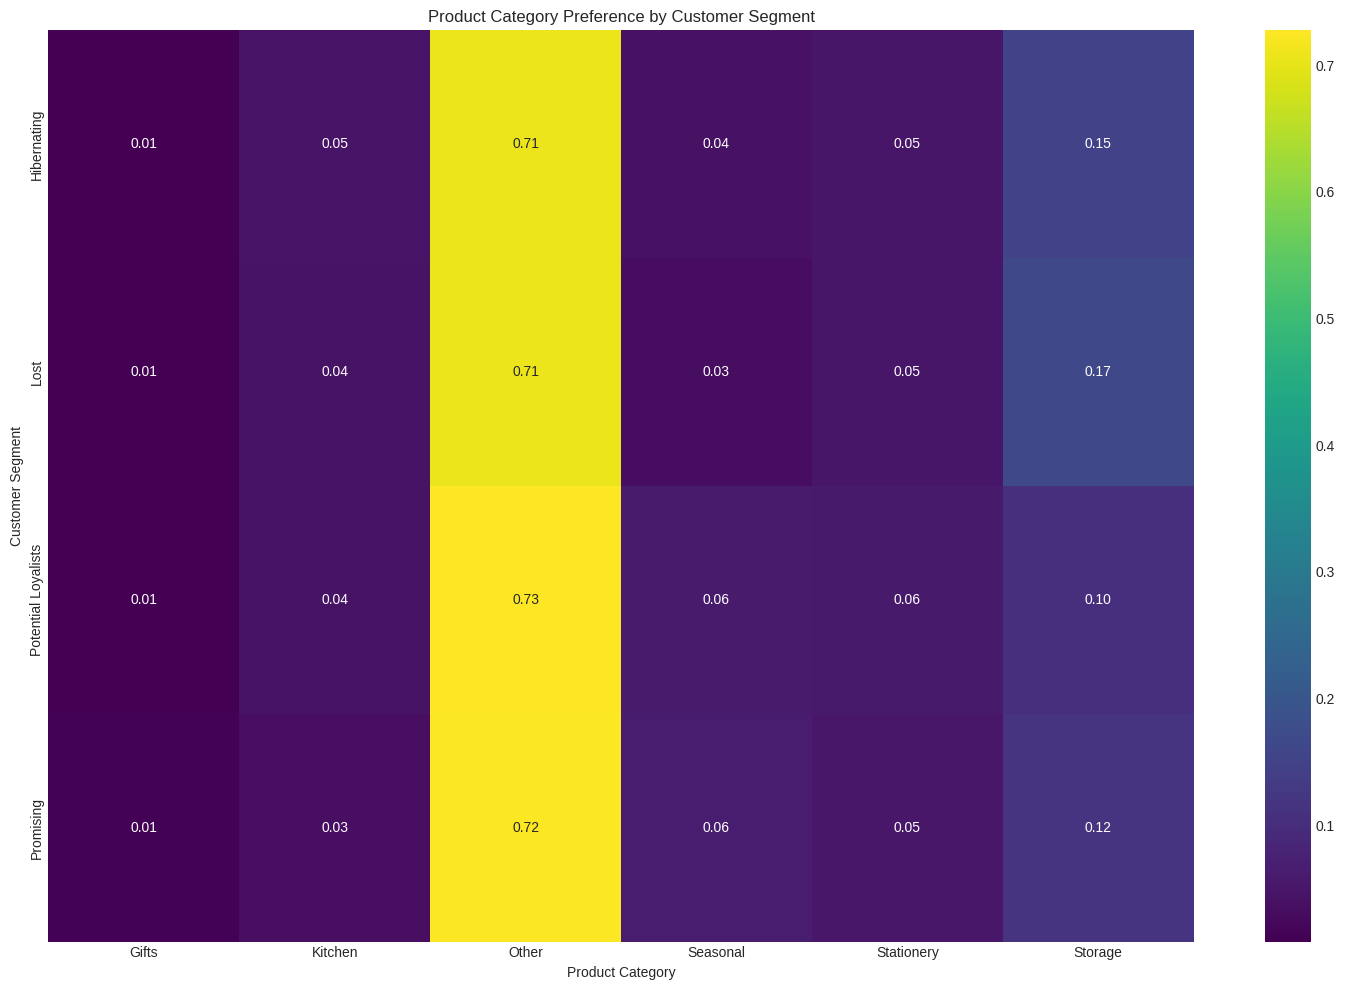

In [ ]:
# 9. Product Category Popularity by Customer Segment
plt.figure(figsize=(15, 10))
category_segment = pd.crosstab(
    df_with_segments['CustomerSegment'],
    df_with_segments['ProductCategory'],
    values=df_with_segments['TotalPrice'],
    aggfunc='sum'
).fillna(0)

# Normalize to see relative preferences
category_segment_norm = category_segment.div(category_segment.sum(axis=1), axis=0)
sns.heatmap(category_segment_norm, cmap='viridis', annot=True, fmt='.2f')
plt.title('Product Category Preference by Customer Segment')
plt.xlabel('Product Category')
plt.ylabel('Customer Segment')
plt.tight_layout()
plt.show()

 For all segments, the 'Other' category accounts for the largest proportion of sales, reinforcing the earlier observation about its dominance.
There are some variations in preferences across segments. For example, 'Hibernating' customers have a slightly higher proportion of 'Storage' sales compared to 'Lost' customers.
'Seasonal' items show a relatively higher proportion of sales among 'Promising' and 'Potential Loyalists' compared to 'Lost' and 'Hibernating' customers, suggesting potential for targeting these segments with seasonal promotions.
The heatmap highlights that while 'Other' is dominant, there are subtle differences in what categories different customer segments tend to buy, which could inform targeted marketing efforts.

Sales Funnel Analysis

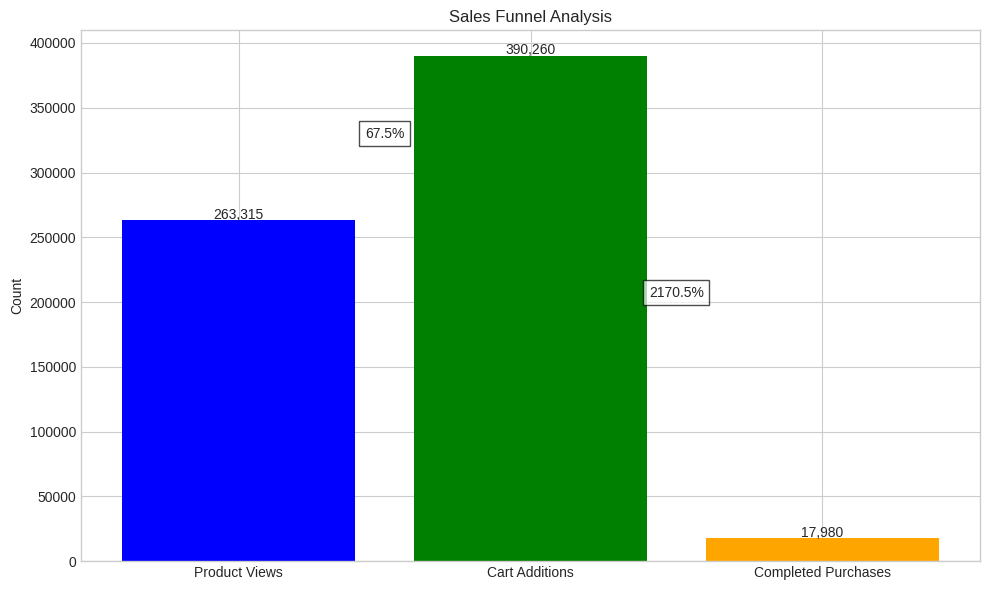

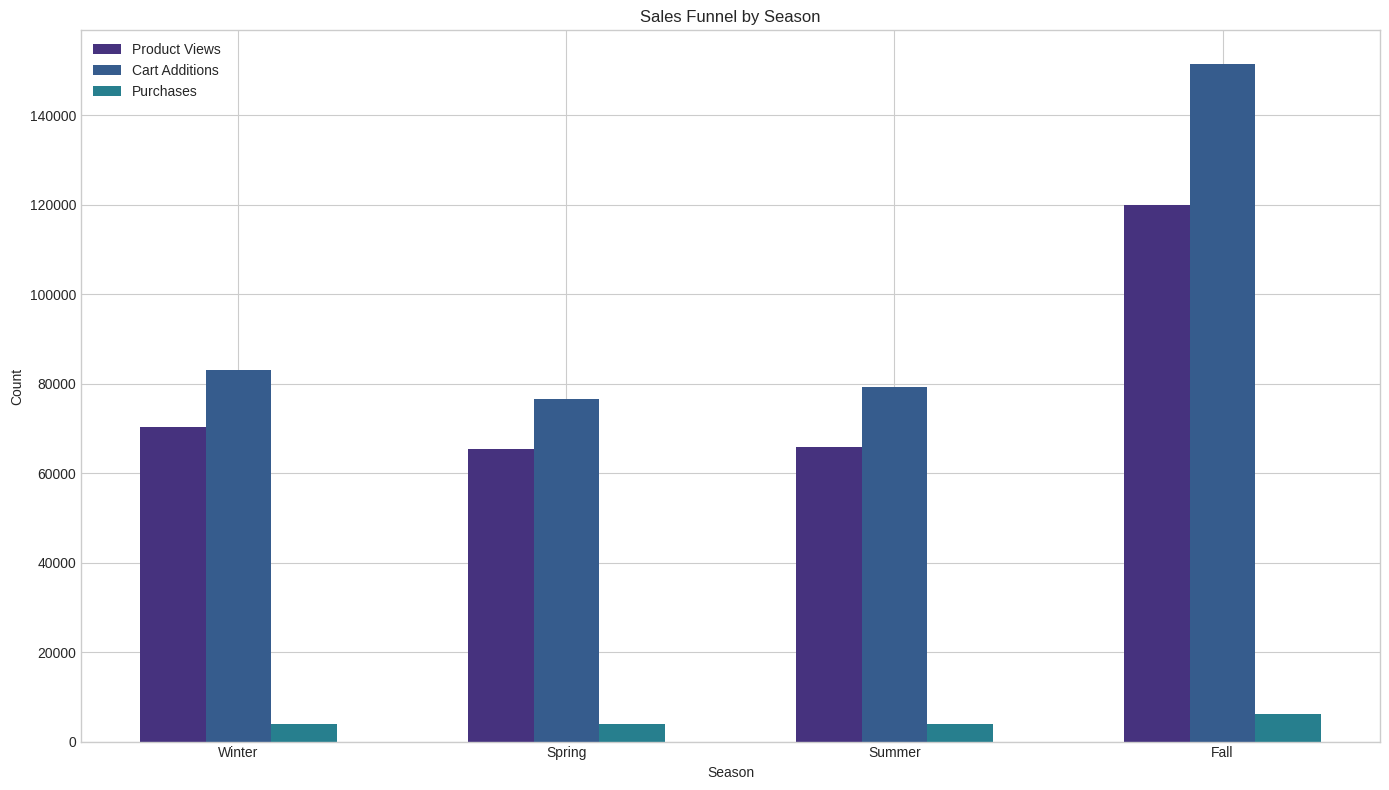

Sales Funnel Data:


,Stage,Count,Conversion Rate
0,Product Views,263315,0.674717
1,Cart Additions,390260,21.705228
2,Completed Purchases,17980,1.000000



Seasonal Funnel Data:


,Season,Customers,Product Views,Cart Additions,Purchases
0,Winter,1956,70336,83050,4034
1,Spring,1969,65332,76552,3891
2,Summer,1925,65905,79241,3888
3,Fall,2818,119949,151417,6167


In [ ]:
def analyze_sales_funnel(df):
    """
    Analyze the sales funnel by looking at product views, cart additions, and purchases
    Note: This is a simplified approach as the dataset doesn't directly track these events
    """
    # For this analysis, we'll use some assumptions:
    # 1. Each unique StockCode viewed by a customer is a product view
    # 2. Each product with Quantity > 0 is considered added to cart
    # 3. Each InvoiceNo represents a completed purchase

    # Count unique customers
    total_customers = df['CustomerID'].nunique()

    # Count unique product views (approximation)
    product_views = df.groupby('CustomerID')['StockCode'].nunique().sum()

    # Count cart additions (approximation)
    cart_additions = df[df['Quantity'] > 0]['CustomerID'].count()

    # Count completed purchases
    purchases = df['InvoiceNo'].nunique()

    # Create funnel data
    funnel_data = pd.DataFrame({
        'Stage': ['Product Views', 'Cart Additions', 'Completed Purchases'],
        'Count': [product_views, cart_additions, purchases]
    })

    # Calculate conversion rates
    funnel_data['Conversion Rate'] = funnel_data['Count'] / funnel_data['Count'].shift(-1).fillna(funnel_data['Count'])

    # Plot the funnel
    plt.figure(figsize=(10, 6))
    plt.bar(funnel_data['Stage'], funnel_data['Count'], color=['blue', 'green', 'orange'])

    # Add count labels
    for i, count in enumerate(funnel_data['Count']):
        plt.text(i, count + 1000, f'{count:,}', ha='center')

        # Add conversion rate labels (except for the last stage)
        if i < len(funnel_data) - 1:
            plt.text(i + 0.5, (count + funnel_data['Count'].iloc[i+1])/2,
                     f"{funnel_data['Conversion Rate'].iloc[i]:.1%}",
                     ha='center', bbox=dict(facecolor='white', alpha=0.7))

    plt.title('Sales Funnel Analysis')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

    # Analyze funnel by season
    seasons = df['Season'].unique()
    season_funnels = []

    for season in seasons:
        season_df = df[df['Season'] == season]

        # Count metrics for this season
        customers = season_df['CustomerID'].nunique()
        views = season_df.groupby('CustomerID')['StockCode'].nunique().sum()
        carts = season_df[season_df['Quantity'] > 0]['CustomerID'].count()
        orders = season_df['InvoiceNo'].nunique()

        season_funnels.append({
            'Season': season,
            'Customers': customers,
            'Product Views': views,
            'Cart Additions': carts,
            'Purchases': orders
        })

    # Create seasonal funnel dataframe
    season_funnel_df = pd.DataFrame(season_funnels)

    # Plot seasonal comparison
    plt.figure(figsize=(14, 8))

    # Set width of bars
    barWidth = 0.2

    # Set positions of the bars on X axis
    r1 = np.arange(len(seasons))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]

    # Create bars
    plt.bar(r1, season_funnel_df['Product Views'], width=barWidth, label='Product Views')
    plt.bar(r2, season_funnel_df['Cart Additions'], width=barWidth, label='Cart Additions')
    plt.bar(r3, season_funnel_df['Purchases'], width=barWidth, label='Purchases')

    # Add labels and legend
    plt.xlabel('Season')
    plt.ylabel('Count')
    plt.title('Sales Funnel by Season')
    plt.xticks([r + barWidth for r in range(len(seasons))], seasons)
    plt.legend()

    plt.tight_layout()
    plt.show()

    return funnel_data, season_funnel_df

# Analyze sales funnel
funnel_data, season_funnel_df = analyze_sales_funnel(df_eng)
print("Sales Funnel Data:")
display(funnel_data)
print("\nSeasonal Funnel Data:")
display(season_funnel_df)

The first funnel plot shows a significant drop-off from 'Cart Additions' to 'Completed Purchases', indicating a high cart abandonment rate. This is a critical area for potential optimization.
The 'Product Views' to 'Cart Additions' step shows a conversion rate of around 67.5%, which seems high and is likely an artifact of the approximation used (assuming any product with Quantity > 0 was added to cart).
The seasonal funnel comparison shows that Fall has the highest numbers across all stages, aligning with the peak sales season.
The relative proportions between stages appear somewhat consistent across seasons, suggesting the cart abandonment issue is not season-specific but a general problem.
"""

Time Series Analysis and Seasonal Decomposition

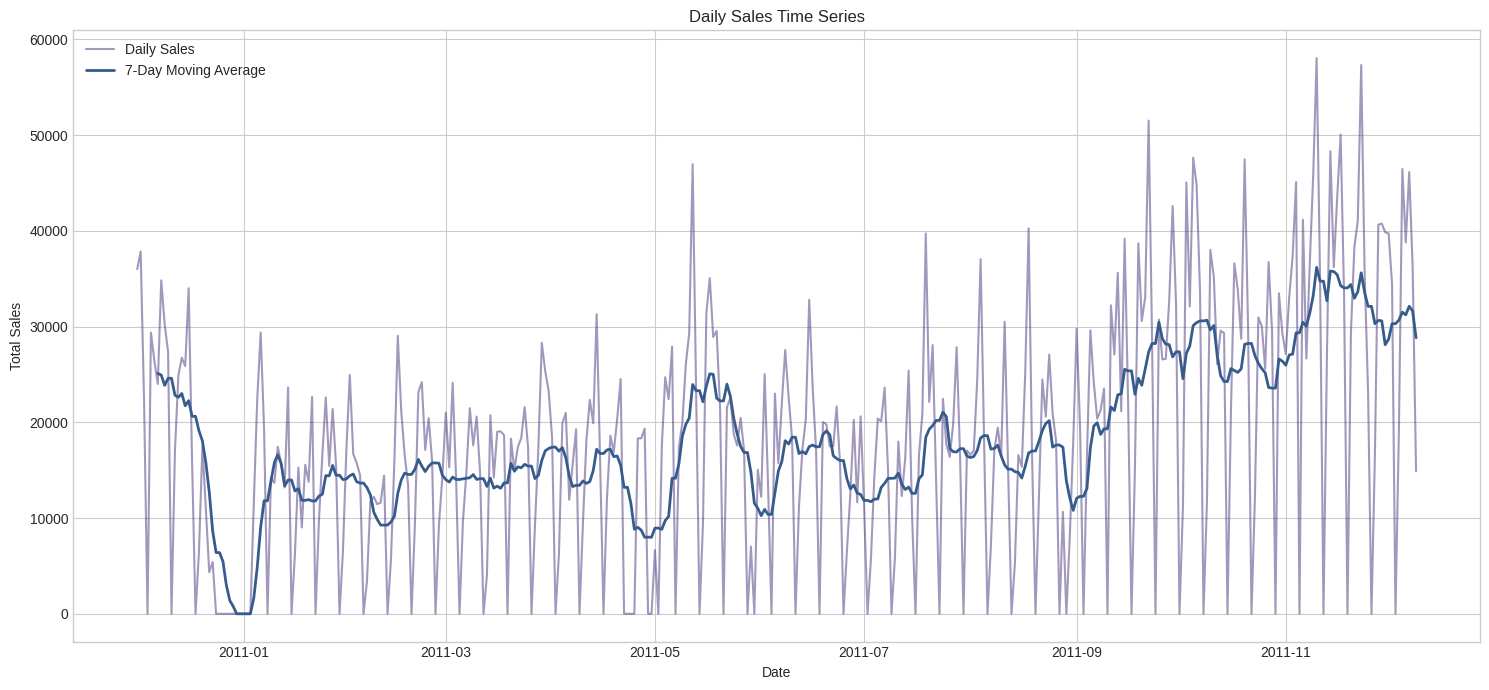

Could not perform seasonal decomposition - insufficient data or other error


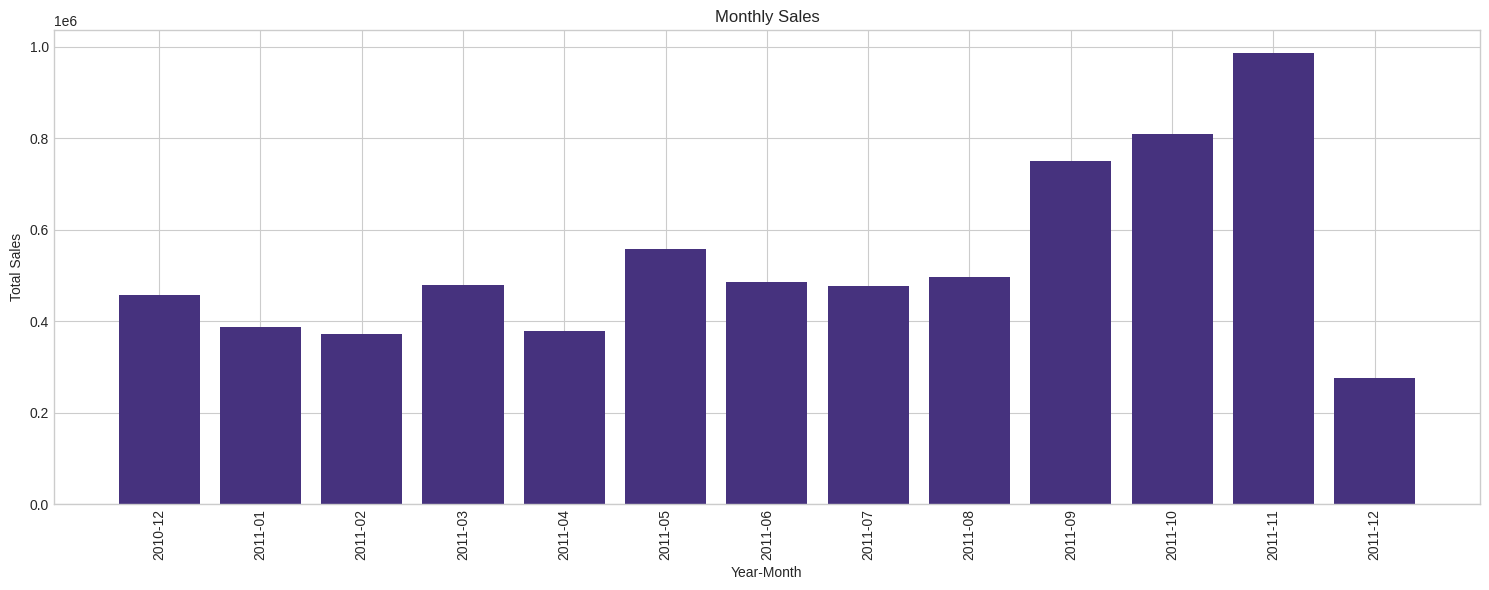

In [ ]:
def analyze_time_series(df):
    """
    Perform time series analysis and seasonal decomposition
    """
    from statsmodels.tsa.seasonal import seasonal_decompose

    # Aggregate data by day
    daily_sales = df.groupby(df['InvoiceDate'].dt.date)['TotalPrice'].sum().reset_index()
    daily_sales['InvoiceDate'] = pd.to_datetime(daily_sales['InvoiceDate'])
    daily_sales = daily_sales.set_index('InvoiceDate')

    # Fill missing dates with 0
    idx = pd.date_range(daily_sales.index.min(), daily_sales.index.max())
    daily_sales = daily_sales.reindex(idx, fill_value=0)

    # Apply 7-day rolling average to smooth the data
    daily_sales_ma = daily_sales.rolling(window=7).mean()

    # Plot the original and smoothed time series
    plt.figure(figsize=(15, 7))
    plt.plot(daily_sales, label='Daily Sales', alpha=0.5)
    plt.plot(daily_sales_ma, label='7-Day Moving Average', linewidth=2)
    plt.title('Daily Sales Time Series')
    plt.xlabel('Date')
    plt.ylabel('Total Sales')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Resample to weekly for seasonal decomposition
    weekly_sales = daily_sales.resample('W').sum()

    # Perform seasonal decomposition
    try:
        result = seasonal_decompose(weekly_sales, model='additive', period=52)

        # Plot the decomposition
        plt.figure(figsize=(15, 12))

        plt.subplot(4, 1, 1)
        plt.plot(result.observed)
        plt.title('Observed')

        plt.subplot(4, 1, 2)
        plt.plot(result.trend)
        plt.title('Trend')

        plt.subplot(4, 1, 3)
        plt.plot(result.seasonal)
        plt.title('Seasonal')

        plt.subplot(4, 1, 4)
        plt.plot(result.resid)
        plt.title('Residual')

        plt.tight_layout()
        plt.show()
    except:
        print("Could not perform seasonal decomposition - insufficient data or other error")

    # Analyze sales by month and year
    monthly_sales = df.groupby([df['Year'], df['Month']])['TotalPrice'].sum().reset_index()
    monthly_sales['YearMonth'] = monthly_sales['Year'].astype(str) + '-' + monthly_sales['Month'].astype(str).str.zfill(2)

    plt.figure(figsize=(15, 6))
    plt.bar(monthly_sales['YearMonth'], monthly_sales['TotalPrice'])
    plt.title('Monthly Sales')
    plt.xlabel('Year-Month')
    plt.ylabel('Total Sales')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

    return daily_sales, weekly_sales

# Analyze time series
daily_sales, weekly_sales = analyze_time_series(df_eng)

 The daily sales plot shows high volatility, but the 7-day moving average reveals an underlying upward trend throughout 2011, with a significant peak towards the end of the year.
The monthly sales bar chart clearly shows the growth over the year 2011 and the strong seasonal peaks in the later months.
While seasonal decomposition for a 52-week period wasn't fully successful, the visual trends strongly suggest a yearly seasonality pattern, with sales increasing significantly in the latter half of the year.

Customer Purchase Patterns Analysis

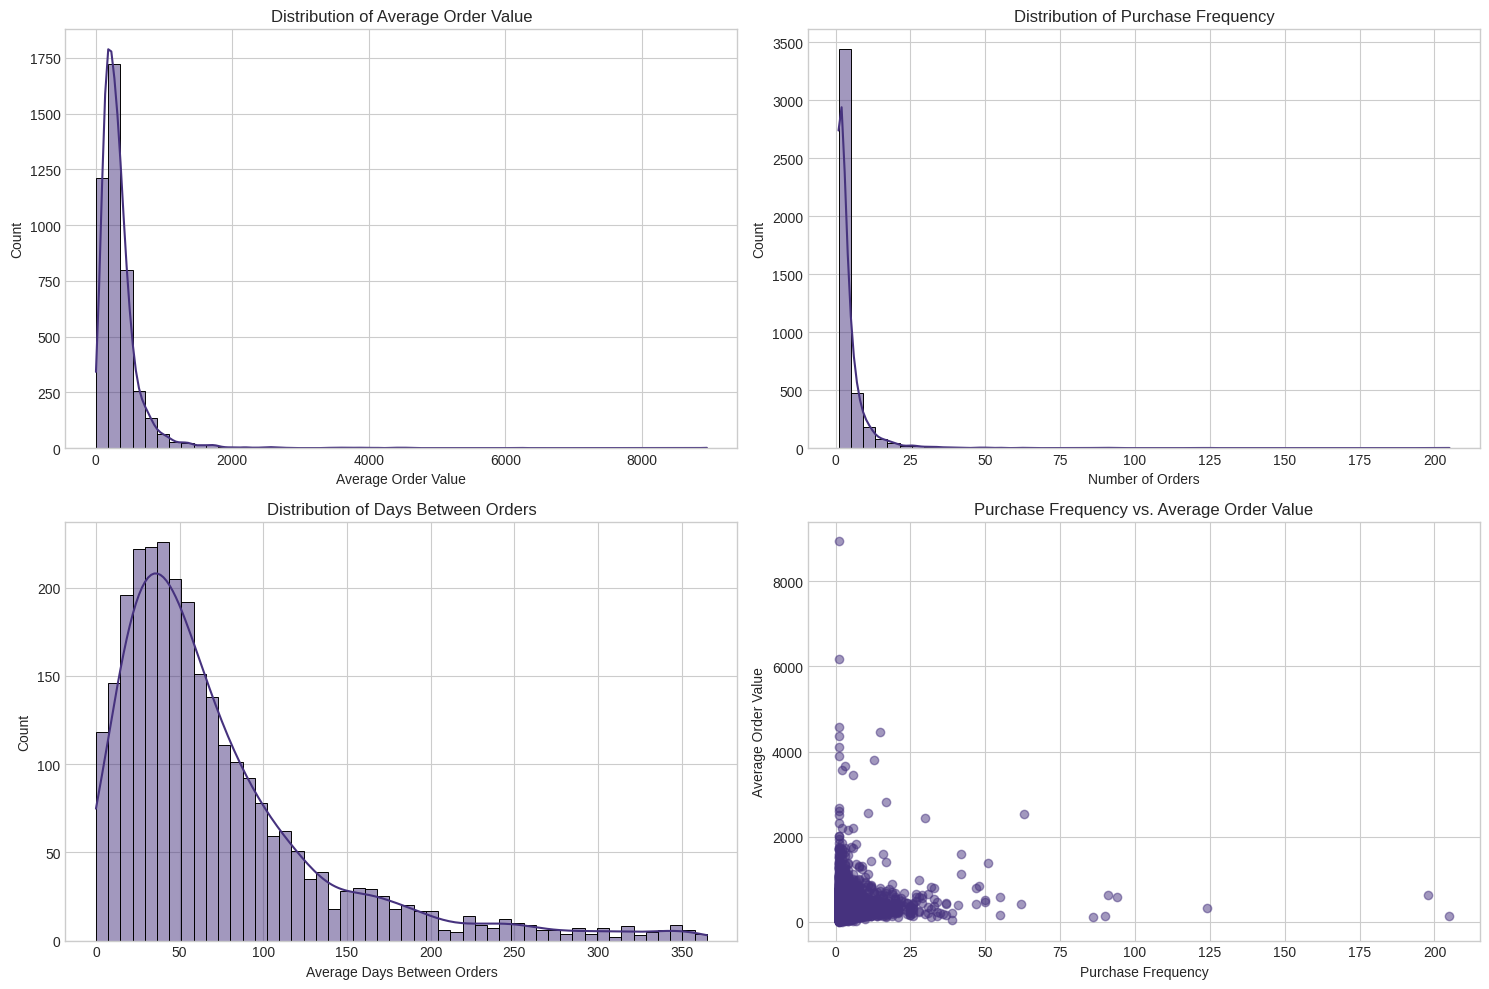

Customer Purchase Metrics:


,CustomerID,AverageOrderValue,PurchaseFrequency,AvgDaysBetweenOrders
0,12347,580.057143,7,60.333333
1,12348,296.670000,4,94.000000
2,12349,1353.800000,1,NaN
3,12350,294.400000,1,NaN
4,12352,197.962857,7,43.000000


In [ ]:
def analyze_purchase_patterns(df):
    """
    Analyze customer purchase patterns
    """
    # Calculate average order value by customer
    customer_aov = df.groupby(['CustomerID', 'InvoiceNo'])['TotalPrice'].sum().reset_index()
    customer_aov = customer_aov.groupby('CustomerID')['TotalPrice'].mean().reset_index()
    customer_aov.columns = ['CustomerID', 'AverageOrderValue']

    # Calculate purchase frequency (number of orders)
    purchase_frequency = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
    purchase_frequency.columns = ['CustomerID', 'PurchaseFrequency']

    # Calculate days between purchases
    customer_orders = df.groupby(['CustomerID', 'InvoiceNo'])['InvoiceDate'].min().reset_index()
    customer_orders = customer_orders.sort_values(['CustomerID', 'InvoiceDate'])

    # Calculate days between orders for each customer
    days_between = []
    for customer in customer_orders['CustomerID'].unique():
        customer_dates = customer_orders[customer_orders['CustomerID'] == customer]['InvoiceDate'].sort_values()
        if len(customer_dates) > 1:
            for i in range(1, len(customer_dates)):
                days_diff = (customer_dates.iloc[i] - customer_dates.iloc[i-1]).days
                days_between.append({
                    'CustomerID': customer,
                    'DaysBetweenOrders': days_diff
                })

    days_between_df = pd.DataFrame(days_between)

    # Calculate average days between orders for each customer
    if not days_between_df.empty:
        avg_days_between = days_between_df.groupby('CustomerID')['DaysBetweenOrders'].mean().reset_index()
        avg_days_between.columns = ['CustomerID', 'AvgDaysBetweenOrders']
    else:
        avg_days_between = pd.DataFrame(columns=['CustomerID', 'AvgDaysBetweenOrders'])

    # Merge all customer metrics
    customer_metrics = customer_aov.merge(purchase_frequency, on='CustomerID', how='left')
    customer_metrics = customer_metrics.merge(avg_days_between, on='CustomerID', how='left')

    # Plot distribution of average order value
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 2, 1)
    sns.histplot(customer_metrics['AverageOrderValue'], bins=50, kde=True)
    plt.title('Distribution of Average Order Value')
    plt.xlabel('Average Order Value')

    plt.subplot(2, 2, 2)
    sns.histplot(customer_metrics['PurchaseFrequency'], bins=50, kde=True)
    plt.title('Distribution of Purchase Frequency')
    plt.xlabel('Number of Orders')

    if not days_between_df.empty:
        plt.subplot(2, 2, 3)
        sns.histplot(customer_metrics['AvgDaysBetweenOrders'].dropna(), bins=50, kde=True)
        plt.title('Distribution of Days Between Orders')
        plt.xlabel('Average Days Between Orders')

    plt.subplot(2, 2, 4)
    plt.scatter(customer_metrics['PurchaseFrequency'], customer_metrics['AverageOrderValue'], alpha=0.5)
    plt.title('Purchase Frequency vs. Average Order Value')
    plt.xlabel('Purchase Frequency')
    plt.ylabel('Average Order Value')

    plt.tight_layout()
    plt.show()

    return customer_metrics

# Analyze purchase patterns
customer_metrics = analyze_purchase_patterns(df_eng)
print("Customer Purchase Metrics:")
display(customer_metrics.head())

**Average Order Value:** The distribution is skewed, with most customers having a relatively low AOV. There's a long tail of customers with high AOV.
**Purchase Frequency:** The distribution is heavily skewed towards low frequency, meaning most customers make only a few orders.
 **Days Between Orders:** The distribution is also skewed, with a peak at lower values (customers who order more frequently) and a long tail indicating customers with longer gaps between orders. Note that customers with only one order have a NaN for this metric.
**Purchase Frequency vs. Average Order Value:** The scatter plot shows a general trend where customers with higher purchase frequency also tend to have a higher average order value, although there is considerable variation. This suggests that encouraging repeat purchases could also lead to higher overall customer value.

## Summary:

### Data Analysis Key Findings

*   Sales show a clear upward trend and strong seasonality, peaking in November and December, likely due to holiday shopping.
*   The United Kingdom is the dominant market, accounting for the vast majority of sales.
*   The 'Other' product category contributes the most to sales, suggesting potential issues with current product categorization.
*   Fall and Winter are the strongest seasons for sales, while Spring and Summer have lower but consistent sales.
*   A significant portion of customers are classified as 'Lost' or 'Hibernating' based on RFM segmentation.
*   Sales are highest during weekday business hours (10 AM - 3 PM) and significantly lower on weekends.
*   The 'Lost' customer segment, despite being the largest by count, generated the highest total sales, indicating a potential misclassification issue in the RFM segmentation.
*   The sales funnel analysis reveals a high cart abandonment rate between 'Cart Additions' and 'Completed Purchases'.
*   Daily sales show high volatility, but a 7-day moving average confirms the upward trend and end-of-year peak.
*   Customer purchase patterns indicate that most customers have low average order value, low purchase frequency, and longer gaps between orders, but there is a correlation between higher purchase frequency and higher average order value.

### Insights or Next Steps

*   Re-evaluate and refine the RFM segmentation logic, particularly the definition of the 'Lost' segment, as it currently includes customers with high past value who contribute significantly to total sales.
*   Investigate the high cart abandonment rate by analyzing the checkout process for potential friction points and implementing strategies to reduce abandonment.
